In [14]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import seaborn
seaborn.set(font_scale=2)
seaborn.set_style('whitegrid')
clrs = seaborn.color_palette()




In [335]:
def sample_neuron(best_resp=12,noiseVar=.4,sigma=.5,nRepeats=6,maxA=1,plot=False):
    
    """ Sample the responses of a neuron
    
        Parameters:
        ----------------
        best_resp:   int
                     the index of frequency of the best response
                     
        noiseVar:    float
                     variance of the response of the neuron
        
        sigma:       float
                     width of the runing curve
        
        nRepeats:   int
                    number of stimulus repetiations to sample
                    
        maxA:       float
                    gain factor for response function
            
        plot:       bool
                    whether to plot the tuning curve + responses
    """
    
    # this defines the response function to the neuron
    g = lambda x: ((np.sqrt(2*np.pi*sigma**2))**-1)*np.exp(-(x-best_resp)**2/(2*sigma**2))*maxA
    
    xs = np.linspace(0,nFreqs,num=900)
    
    resps = [(x,(np.random.random()<.05)*np.random.random()+np.random.normal(loc=g(x),scale=noiseVar*(g(x)*1.2+.3),size=1))
         for x in np.repeat(np.linspace(0,nFreqs-1,num=nFreqs),repeats=nRepeats)]
    
    y = [i[1] for  i in resps]
    x = np.unique([i[0] for i in resps])
    
    if plot:
        plt.plot(xs, g(xs))
        for i,resp in enumerate(resps):
            plt.scatter(resp[0],resp[1],marker='+',s=36,color=clrs[0])
    
    return resps, x, y, g

In [336]:
def makebv(x,t):
    phi = np.pi*x
    a = .5
    c = 0
    x = a*(t+c)*np.pi
    a2 = (1/2)*np.cos( (x - phi) )+ 1/2
    if type(x)!=float:
        a3 = np.array([1 if (i>(phi-np.pi) and i<(phi+ np.pi)) else 0 for i in x])
    else:
        a3 = 1 if (x>(phi-np.pi) and x<(phi+ np.pi)) else 0 
    out = a2*a3
    return out


In [337]:
def basis_value(phi_offset,t,single_value=False,**kwargs):
    
    """ Apply a raised cosine basis function to the input
    
        Parameters:
        ---------------
        
        phi_offset:    float
                       this parameter controls the offset of the
                       cosine basis function from the point t=0
        
        t:             float
                       the input value to the basis function
                    
        single_value:  bool
                       whether t is just a single value or not
        
        
        Returns:
        ---------------
        
        out:           float | array
                       the value of the basis function at the value t
    """
    
    kwargs.setdefault('a',.5) #Parameter controlling the width of the basis functions
    kwargs.setdefault('c',0)  #another basis function parameter
    a = kwargs['a']
    c = kwargs['c']
    
    phi = np.pi*phi_offset
    
    
    x = a*(t+c)*np.pi
    a2 = (1/2)*np.cos( (x - phi) )+ 1/2
    if not single_value:
        a3 = np.array([1 if (i>(phi-np.pi) and i<(phi+ np.pi)) else 0 for i in x])
    else:
        a3 = 1 if (x>(phi-np.pi) and x<(phi+ np.pi)) else 0 
    out = a2*a3
    return out


In [338]:
def project_X(xs,basis_type,**kwargs):
    """ Project an array of 1-D value into a space parameterised by
        a series of raised cosine basis functions 
        (see also function basis value)
        
        Parameters:
        ------------
        
        
        xs:            array
                       input points
                       
        basis_type:    str E (cos, boxcar)
                       type of basis to use. Default is boxcar. 
                       
        kwargs:              
                       phi_params:    array
                                      parameters for the raised cosine basis function
                       
        
                       
        Returns:
        -----------
        X:             array
                       an array of size (len(phi_params),len(xs)),
                       corresponding to the projection of the data
                       into the space of all basis functions
    """
    
    if 'cos' in basis_type:
        
        kwargs.setdefault('a',.3) #Parameter controlling the width of the basis functions
        kwargs.setdefault('c',0)  #another basis function parameter

        
        
        
        phi_params = kwargs['phi_params']
        a = kwargs['a']
        c = kwargs['c']
        X = []
        for x in xs:
            temp = []
            for phi in phi_params:
                #print type(x)==float
                temp.append(basis_value(phi,float(x),single_value=1,a=a,c=c))
            X.append(temp)
        X = np.array(X).T
    else:
        X = np.zeros([np.max(xs)+1,len(xs)])
        for i,x in enumerate(xs):
            X[int(x),int(i)] = 1
            
    return X



In [339]:
class linear_RF_model(object):
    
    """ Linear Bayesian Receptive Field Model """
    
    
    def __init__(self,name,responses,g,frqs,phi_params,a,c):
        
        """ Initialise with Data and Responses Function
        
        Parameters:
        ------------
        name        int | str
                    something to index your neuron by
        
        responses   list of tuples
                    a list of tuples (x,y) of the non-projected x and y values
        
        g           function
                    the response function of the neuron
                    
                    
        frqs        array
                    frequencies of sounds used as stimuli
                    
        phi_params  array
                    parameter values passed to the basis functions
                    
        """
        
        self.name=name
        self.g = g
        self.frqs = frqs
        self.responses = responses
        self.respFs = [i[0] for i in self.responses]
        self.nFreqs = len(np.unique(self.respFs))
        self.phi_params = phi_params
        self.a = a
        self.c = c
        
    
    def add_prior(self,prior_cov):
        self.cov_prior = prior_cov
        self.prior = multivariate_normal(mean=np.zeros(prior_cov.shape[0]),
                                         cov=prior_cov)
    def add_data(self,X,Y,noiseVar=.5):
        self.X = X
        self.Y = Y
        self.noiseVar = noiseVar
    
    def infer_posterior(self):
        self.posterior_cov = np.linalg.inv((self.noiseVar**-2)*self.X.dot(self.X.T) + \
                                           np.linalg.inv(self.cov_prior))
        self.posterior_mu = (self.noiseVar**-2)*self.posterior_cov.dot(self.X).dot(self.Y)
        
        ###Define the posterior distribution
        posterior = multivariate_normal(mean=self.posterior_mu.flatten(),cov=self.posterior_cov)
    
    def plot_posterior(self,basis_type='boxcar'):
        
        """ Plot the Posterior Together with the data """
        x_samps = np.linspace(0,self.nFreqs-1,num=900)
        X = project_X(x_samps,basis_type=basis_type,phi_params=self.phi_params,a=self.a,c=self.c)

        pMu = X.T.dot(self.posterior_mu)

        boxcar_mu = self._get_boxcar()
        
        y = [i[1] for  i in self.responses]

        self.ppSD = self._calc_posterior_uncertainty(X)

        plt.figure(figsize=(12,6))

        plt.plot(x_samps, self.g(x_samps),
                 color=[.8,.2,.2],linewidth=3,label='$True Function$')
        


        
       
        
        for i,resp in enumerate(self.responses):
            plt.scatter(resp[0],resp[1],marker='+',color=clrs[0])
        plt.scatter(resp[0],resp[1],marker='+',label=r'raw data')
        plt.plot(x_samps,pMu.flatten(),'.-',color='k',label=r'$posterior \ mean$')
        
        plt.plot(x_samps,pMu.flatten() + self.ppSD,'--',color='k')
        plt.plot(x_samps,pMu.flatten() - self.ppSD,'--',color='k',label=r'$\pm2SD$')
        
        plt.plot(range(self.nFreqs),boxcar_mu,'.-',label=r'$empirical \ mean$')
        plt.xticks(range(self.nFreqs)[::2],np.round(self.frqs/1000,decimals=1)[::2])
        plt.xlim(0,self.nFreqs-1)
        plt.xlabel('Frequency (kHz)')
        plt.legend(loc='best')

    def _get_boxcar(self):
        boxcar_mu = np.zeros(nFreqs)
        ctr = np.zeros(nFreqs)
        for i,resp in self.responses:
            ctr[i] += 1
            boxcar_mu[i] += resp
           
        return boxcar_mu / ctr
    
    def plot_predictive_dist(self,newX):
        
        x_star = project_X(phi_params,newX)
        A = np.linalg.inv((self.noiseVar**-2)*self.X.dot(self.X.T) + np.linalg.inv(self.cov_prior))
        pred_cov = x_star.dot(A).dot(x_star.T)
        pred_mean = (self.noiseVar**-2)*x_star.dot(A).dot(self.X).dot(self.Y)
        pred_2sd = 2*np.sqrt(np.diag(pred_cov))
        plt.plot(newX,pred_mean)
        plt.plot(newX,pred_mean-pred_2sd,'--',color='k')
        plt.plot(newX,pred_mean+pred_2sd,'--',color='k')
    
    def _calc_posterior_uncertainty(self,X):
        
        """ return 2*SD of the posterior uncertainty at a set of points """
        
        post_pred_var = np.diag(X.T.dot(self.posterior_cov).dot(X))
        return 2*np.sqrt(post_pred_var)

##  Now Run Code for a Spin

(5, 20)

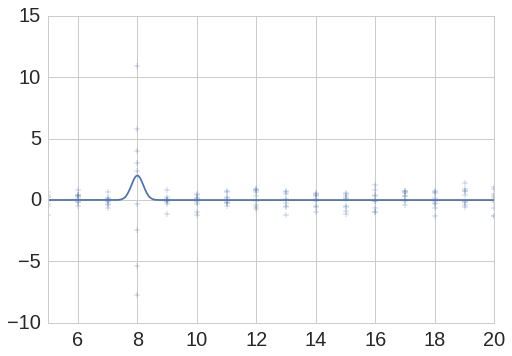

In [340]:
nFreqs = 25; frqs = np.array(range(nFreqs))

resps,x,y,g = sample_neuron(best_resp=8,noiseVar=2,sigma=.2,nRepeats=9,plot=True)
plt.xlim(5,20)

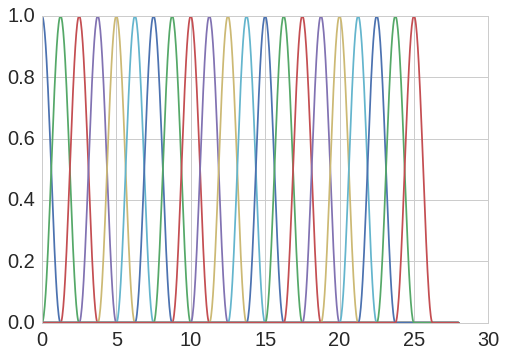

In [341]:
phi_params = np.linspace(0,20,num=21)


t = np.linspace(0,nFreqs+3,num=900)
for phi in phi_params:
    plt.plot(t,basis_value(phi,t,a=.8,c=.00))

In [342]:
x_locs = [i[0] for i in resps]
X = project_X(x_locs,basis_type='cos',phi_params=phi_params,a=.8,c=0)

In [343]:
rf = linear_RF_model(1,
                     responses=resps,
                     g=g,
                     frqs=frqs,
                     phi_params=phi_params,
                     a=.8,
                     c=0)

In [344]:
rf.add_prior(np.eye(X.shape[0])*3)
rf.add_data(X,y)
rf.infer_posterior()

/home/yves/.local/lib/python2.7/site-packages/ipykernel/__main__.py:99: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/yves/.local/lib/python2.7/site-packages/ipykernel/__main__.py:100: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


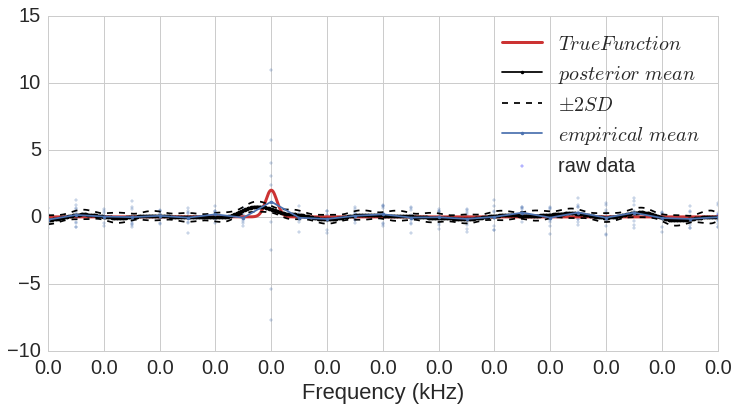

In [345]:
rf.plot_posterior(basis_type='cos')


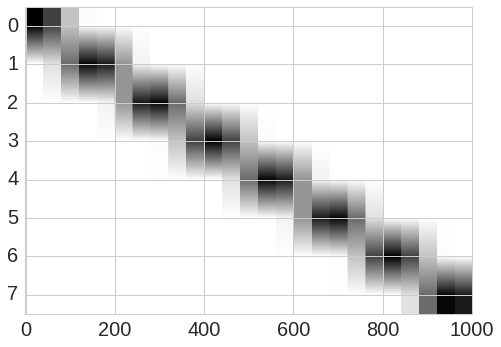

In [244]:
plt.imshow(X,aspect='auto')

In [245]:
X = project_X(x_locs,basis_type='cos',phi_params=phi_params)
X.shape

(8, 1000)